# **Previsão do Preço do Bitcoin (BTC-USD) com Machine Learning**

Este projeto visa prever o preço de Bitcoin. Para isso foram testados diversos modelos de machine learning. Utilizaremos dados históricos obtidos do      

## **Importação de Bibliotecas**

In [257]:
# Coleta de dados
import requests
import pandas as pd
import numpy as np
import yfinance as yf

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import random
import joblib

# Séries Temporais
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from prophet import Prophet

# Outras
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## **1. Coleta de Dados via CoinGecko API**

Para este projeto, optamos por coletar os dados históricos do Bitcoin utilizando a **[CoinGecko API](https://www.coingecko.com/en/api)**, uma das fontes mais confiáveis e amplamente utilizadas no ecossistema de criptomoedas. A CoinGecko agrega dados de múltiplas exchanges globais, oferecendo uma média representativa do preço do Bitcoin em tempo real.

A API utilizada fornece dados estruturados em formato JSON, com alta precisão e cobertura temporal consistente. Para esta análise, estamos interessados apenas no **preço de fechamento diário** do Bitcoin em dólares americanos (USD), coletado ao longo dos últimos 90 dias.

Os dados retornados pela API contêm duas informações principais:
- `timestamp`: Data e hora do registro em milissegundos (formato Unix)
- `price`: Preço de fechamento do Bitcoin em USD

Após a coleta, realizamos as seguintes transformações:
1. Conversão do `timestamp` para formato datetime legível.
2. Definição da data como índice do DataFrame.
3. Renomeação da coluna para `btc_close`, indicando claramente a origem do dado.

Este processo garante que os dados estejam limpos, estruturados e prontos para a próxima etapa: análise exploratória e modelagem preditiva.

In [258]:
def coletar_bitcoin():
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': dias, 
        'interval': 'daily'
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.drop('timestamp', axis=1, inplace=True)
    df.set_index('date', inplace=True)
    return df[['close']].rename(columns={'close': 'btc_close'})

dias = 90
df_btc = coletar_bitcoin()
print(f"Dados do Bitcoin coletados: {len(df_btc)} dias")
df_btc.head()

Dados do Bitcoin coletados: 91 dias


,btc_close
date,
2025-07-01,107132.799107
2025-07-02,105613.399742
2025-07-03,108824.444232
2025-07-04,109602.204839
2025-07-05,108040.891940


## **2. Coleta de Variáveis Exógenas: Ampliando o Contexto do Modelo**

Para melhorar a capacidade preditiva do nosso modelo, incorporamos **variáveis exógenas** — fatores externos que podem influenciar o preço do Bitcoin, mesmo que indiretamente. Em mercados financeiros, especialmente em criptomoedas, o comportamento dos preços raramente depende apenas da série histórica; ele é fortemente impactado por sentimentos do mercado, ativos correlacionados e indicadores macroeconômicos.

Neste projeto, selecionamos três variáveis estratégicas:
1. **Fear & Greed Index (Índice de Medo e Ganância)** – para capturar o sentimento coletivo do mercado.
2. **Preço do Ethereum (ETH-USD)** – como principal altcoin, tem forte correlação com o Bitcoin.
3. **Índice Dólar (DXY)** – reflete a força da moeda americana, influenciando fluxos de capital global.

A seguir, detalhamos a coleta e justificativa de cada uma dessas variáveis.

### 2.1 Fear & Greed Index: Medindo o Sentimento do Mercado

O [**Crypto Fear & Greed Index**](https://alternative.me/crypto/fear-and-greed-index/) é uma métrica amplamente utilizada na comunidade de criptomoedas para quantificar o sentimento coletivo dos investidores. Ele varia de 0 (extremo medo) a 100 (extremo ganância), sendo calculado com base em:
- Volatilidade de preço
- Volume de negociação
- Opinião nas redes sociais
- Pesquisa do Google
- Tendências no mercado de derivativos

Em períodos de **medo extremo**, muitos investidores vendem, pressionando os preços para baixo — o que pode representar oportunidades de compra. Já em momentos de **ganância extrema**, há risco de correção brusca.

Incluir essa variável no modelo permite que ele "sinta" o clima do mercado, melhorando sua capacidade de antecipar movimentos emocionais, não apenas técnicos.

> **Fonte**: https://alternative.me/crypto/fear-and-greed-index/

In [259]:
def coletar_fear_greed():
    url = f"https://api.alternative.me/fng/?limit={dias}&format=json"
    response = requests.get(url)
    data = response.json()
    
    fgi_list = [(item['timestamp'], int(item['value'])) for item in data['data']]
    df_fgi = pd.DataFrame(fgi_list, columns=['date', 'fgi'])
    df_fgi['date'] = pd.to_datetime(df_fgi['date'], unit='s')
    df_fgi.set_index('date', inplace=True)
    return df_fgi

df_fgi = coletar_fear_greed()
df_fgi.head()

,fgi
date,
2025-09-28,37
2025-09-27,33
2025-09-26,28
2025-09-25,44
2025-09-24,44


### 2.2 Ethereum (ETH-USD): O Principal Ativo Correlacionado

O Ethereum é a segunda maior criptomoeda por capitalização de mercado e historicamente apresenta **alta correlação com o Bitcoin**. Muitas vezes, ambos os ativos sobem ou caem juntos, especialmente em eventos de grande impacto, como notícias regulatórias, mudanças tecnológicas (ex: atualizações da rede) ou movimentações macroeconômicas.

Além disso, o ecossistema DeFi, NFTs e staking são construídos majoritariamente sobre a blockchain do Ethereum, tornando-o um termômetro da saúde do mercado de criptoativos como um todo.

Por isso, incluir o preço do Ethereum como variável exógena ajuda o modelo a identificar padrões de mercado mais amplos, além do comportamento isolado do Bitcoin.

> **Fonte**: Dados coletados via `yfinance` usando o ticker `ETH-USD`.

In [260]:
def coletar_eth():
    eth = yf.Ticker("ETH-USD")
    hist = eth.history(period="3mo")
    return hist[['Close']].rename(columns={'Close': 'eth_close'})[-dias:]

df_eth = coletar_eth()
df_eth.head()

,eth_close
Date,
2025-07-01 00:00:00+00:00,2405.792725
2025-07-02 00:00:00+00:00,2571.335449
2025-07-03 00:00:00+00:00,2591.007324
2025-07-04 00:00:00+00:00,2508.518311
2025-07-05 00:00:00+00:00,2517.280029


### 2.3 Índice Dólar (DXY): O Impacto Macroeconômico

O **Índice Dólar (DXY)** mede o valor do dólar americano em relação a uma cesta de moedas globais (como euro, iene, libra). Ele é um indicador-chave da força da economia dos EUA e influencia diretamente os fluxos de capital internacional.

Quando o DXY **sobe**, o dólar se fortalece, o que pode levar investidores a vender ativos de risco (como criptomoedas) para buscar segurança em ativos denominados em USD. Por outro lado, quando o DXY **cai**, há maior apetite por risco, o que beneficia ativos voláteis como o Bitcoin.

Incluir o DXY no modelo permite que ele considere o cenário macroeconômico global — uma peça essencial para previsões realistas em um ativo como o Bitcoin, que opera em um mercado internacional 24/7.

> **Fonte**: Dados coletados via `yfinance` usando o ticker `DX-Y.NYB`.

In [261]:
def coletar_dxy():
    dxy = yf.Ticker("DX-Y.NYB")
    hist = dxy.history(period="3mo")
    return hist[['Close']].rename(columns={'Close': 'dxy'})[-dias:]

df_dxy = coletar_dxy()
df_dxy.head()

,dxy
Date,
2025-06-30 00:00:00-04:00,96.879997
2025-07-01 00:00:00-04:00,96.820000
2025-07-02 00:00:00-04:00,96.779999
2025-07-03 00:00:00-04:00,97.180000
2025-07-07 00:00:00-04:00,97.480003


## **3. Junção e Limpeza dos Dados: Construindo um Conjunto Multivariado Coerente**

Agora que coletamos os dados principais do Bitcoin e três variáveis exógenas relevantes — **Fear & Greed Index**, **Ethereum (ETH-USD)** e **Índice Dólar (DXY)** — precisamos combiná-los em um único DataFrame estruturado e limpo, pronto para modelagem.

Esse passo é crítico porque:
- Cada fonte de dados pode ter **frequência diferente**, **fusos horários distintos** ou **dias faltantes**.
- Se não alinharmos corretamente os índices temporais, criaremos **dados incorretos ou vazios**, comprometendo todo o modelo.

### Desafios Encontrados

Durante a junção, identificamos um problema comum em análises com múltiplas fontes:
* **Conflito de timezone**: alguns DataFrames tinham índice com fuso horário (`tz-aware`), enquanto outros eram `tz-naive`.

Isso impediria a operação `.join()` do Pandas. A solução foi padronizar todos os índices para `tz-naive`, garantindo compatibilidade sem perda de informação temporal.

### Processo de Limpeza

Para preparar os dados, realizamos as seguintes etapas:

1. **Padronização do índice**: Remoção do timezone de todos os DataFrames.
2. **Junção por data**: Alinhamento dos registros usando a coluna de data como índice.
3. **Preenchimento de lacunas**: Uso de `ffill` (*forward fill*) para preencher valores nulos com o último valor válido — uma prática comum em séries financeiras.
4. **Remoção de restantes nulos**: Após o preenchimento, removemos eventuais linhas ainda incompletas.

O resultado é um conjunto de dados multivariado, sincronizado e consistente, onde cada linha representa um dia com:
- Preço do Bitcoin
- Sentimento do mercado (FGI)
- Preço do Ethereum
- Valor do Dólar (DXY)

Este dataset agora está pronto para alimentar modelos mais robustos, como o LSTM, que podem aproveitar essas relações para melhorar a precisão das previsões.

In [ ]:
# Função para converter índice para tz-naive
def to_tz_naive(df):
    """
    Converte índice com timezone para tz-naive.
    Funciona apenas se o índice for DatetimeIndex.
    """
    if isinstance(df.index, pd.DatetimeIndex):
        if df.index.tz is not None:
            return df.tz_localize(None)
        else:
            return df
    else:
        # Se não for DatetimeIndex, avise e retorne original
        print(f"Índice não é DatetimeIndex. Tipo atual: {type(df.index)}")
        return df

# Converter todos os DataFrames para tz-naive
df_btc_clean = to_tz_naive(df_btc.copy())
df_fgi_clean = to_tz_naive(df_fgi)
df_eth_clean = to_tz_naive(df_eth)
df_dxy_clean = to_tz_naive(df_dxy)

# Agora podemos juntar sem erro
df_final = df_btc_clean
df_final = df_final.join(df_fgi_clean, how='left')
df_final = df_final.join(df_eth_clean, how='left')
df_final = df_final.join(df_dxy_clean, how='left')

# Preencher valores nulos (forward-fill)
df_final.fillna(method='ffill', inplace=True)
df_final.dropna(inplace=True)

print("Dados combinados com sucesso!")
print(f"Forma final: {df_final.shape}")
print("\nInformações do índice:")
print(f"Tipo: {type(df_final.index)}")
print(f"Fuso horário: {df_final.index.tz}")

# Mostrar primeiras linhas
df_final.head()

Dados combinados com sucesso!
Forma final: (91, 4)

Informações do índice:
Tipo: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Fuso horário: None


,btc_close,fgi,eth_close,dxy
date,,,,
2025-07-01,107132.799107,64.0,2405.792725,96.820000
2025-07-02,105613.399742,63.0,2571.335449,96.779999
2025-07-03,108824.444232,73.0,2591.007324,97.180000
2025-07-04,109602.204839,73.0,2508.518311,97.180000
2025-07-05,108040.891940,67.0,2517.280029,97.180000


## **4. Análise Exploratória de Dados (EDA): Entendendo o Comportamento do Mercado**

Com os dados coletados, combinados e limpos, chegou o momento de mergulhar fundo na análise exploratória. O objetivo aqui é responder perguntas fundamentais:
- Qual é o comportamento geral do preço do Bitcoin?
- Como estão distribuídos os preços?
- Existe sazonalidade ou tendência clara?
- Quais variáveis mais influenciam o movimento do BTC?
- O mercado está em estado de medo ou ganância?

Essa etapa é crucial porque **um bom modelo de Machine Learning começa com uma boa compreensão dos dados**. Através de visualizações e estatísticas descritivas, vamos mapear o terreno antes de construir qualquer previsão.

### 4.1 Estatísticas Descritivas

In [263]:
desc = df_final.describe()
print(desc)

# Coeficiente de variação do BTC
cv_btc = (desc.loc['std', 'btc_close'] / desc.loc['mean', 'btc_close']) * 100
print(f"\nCoeficiente de Variação do BTC: {cv_btc:.2f}%")

# Interpretação rápida
if cv_btc > 30:
    print("Alta volatilidade detectada — típico de ativos cripto.")
else:
    print("Volatilidade moderada.")

           btc_close        fgi    eth_close         dxy
count      91.000000  91.000000    91.000000   91.000000
mean   114359.857218  59.153846  3930.127240   97.945143
std      3841.266708  11.995298   645.061433    0.588983
min    105613.399742  28.000000  2405.792725   96.629997
25%    111203.133447  49.500000  3620.801514   97.595001
50%    115359.983467  60.000000  4153.469238   97.849998
75%    117521.012452  71.000000  4433.084473   98.259998
max    123560.993636  79.000000  4831.348633  100.029999

Coeficiente de Variação do BTC: 3.36%
Volatilidade moderada.


### 4.2 Gráfico de Série Temporal do Preço de Fechamento do Bitcoin

O gráfico abaixo mostra a evolução do preço de fechamento do Bitcoin ao longo dos últimos 90 dias. É essencial observar tendências de médio prazo, picos e quedas bruscas, e possíveis ciclos de alta e correção.

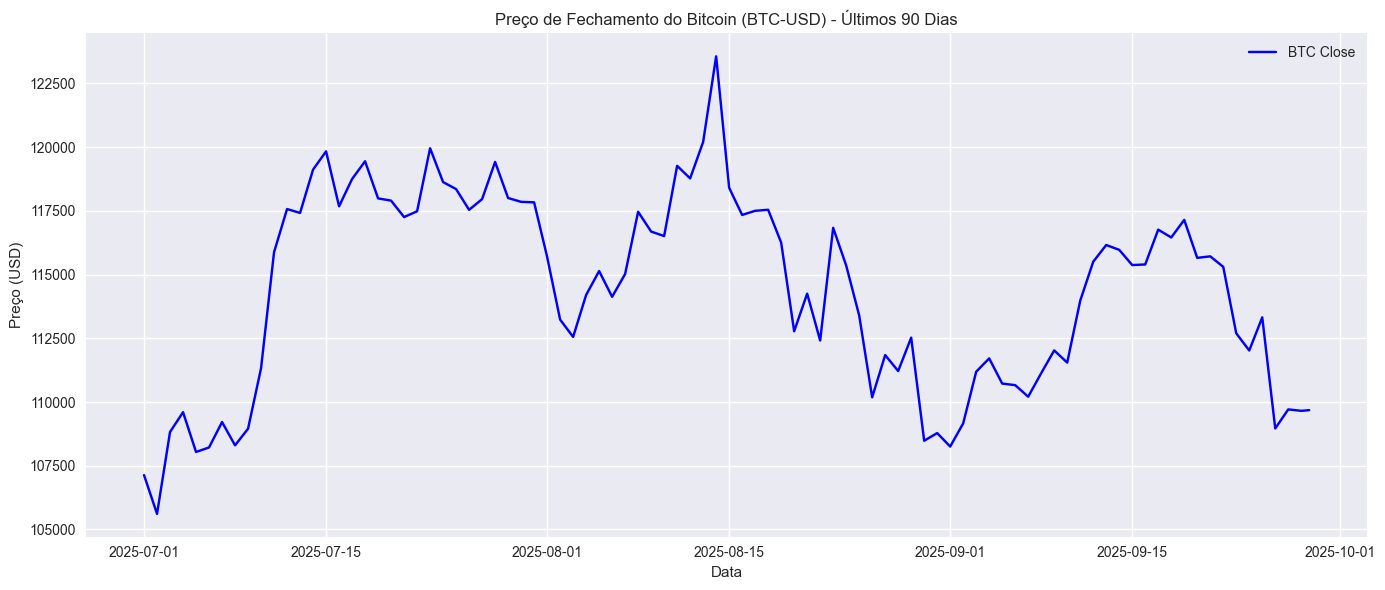

In [264]:
plt.figure(figsize=(14, 6))
plt.plot(df_final.index, df_final['btc_close'], label='BTC Close', color='blue')
plt.title(f'Preço de Fechamento do Bitcoin (BTC-USD) - Últimos {dias} Dias')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.3 Histograma e Distribuição do Preço do Bitcoin
Um histograma ajuda a entender como os preços estão distribuídos. Em mercados eficientes, esperamos uma distribuição próxima à normal, mas em criptomoedas, é comum ver assimetrias e caudas longas, indicando eventos extremos (como pump and dump).

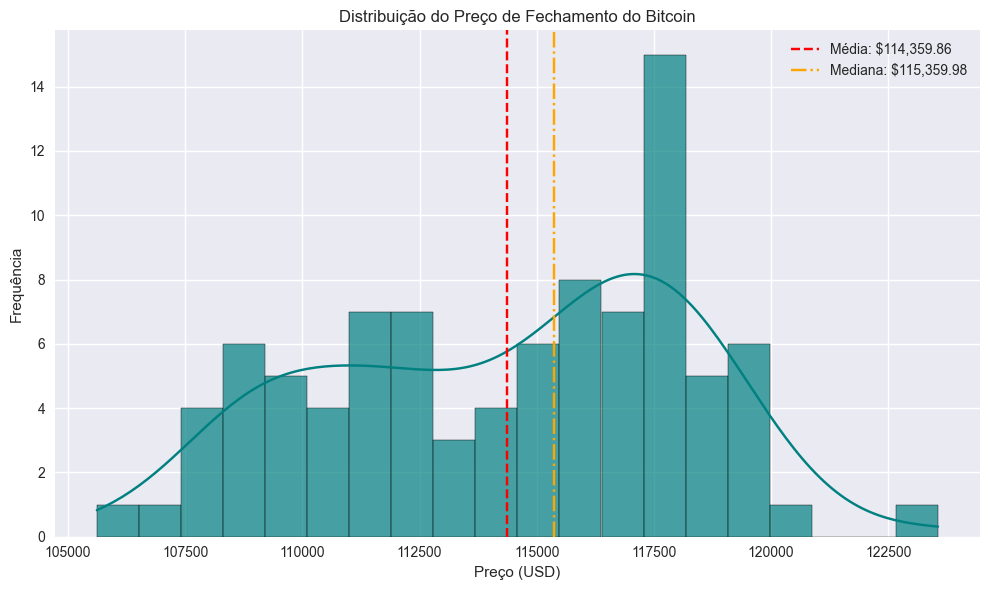

Média: $114,359.86
Mediana: $115,359.98
Desvio Padrão: $3,841.27


In [265]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['btc_close'], bins=20, kde=True, color='teal', alpha=0.7)
plt.axvline(df_final['btc_close'].mean(), color='red', linestyle='--', label=f'Média: ${df_final["btc_close"].mean():,.2f}')
plt.axvline(df_final['btc_close'].median(), color='orange', linestyle='-.', label=f'Mediana: ${df_final["btc_close"].median():,.2f}')
plt.title('Distribuição do Preço de Fechamento do Bitcoin')
plt.xlabel('Preço (USD)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Média: ${df_final['btc_close'].mean():,.2f}")
print(f"Mediana: ${df_final['btc_close'].median():,.2f}")
print(f"Desvio Padrão: ${df_final['btc_close'].std():,.2f}")

### 4.4 Boxplot: Análise da Dispersão e Identificação de Outliers

O **boxplot** (ou gráfico de caixa) é uma representação visual poderosa para entender a distribuição dos dados, destacando:
- Mediana (linha central)
- Quartis (caixa)
- Limites inferior e superior (bigodes)
- Valores atípicos (*outliers*), representados como pontos fora dos bigodes

No contexto do preço do Bitcoin, esperamos ver alguma variabilidade, mas **não necessariamente outliers extremos**, pois o mercado, apesar de volátil, tende a se mover de forma contínua na escala diária. A presença de *outliers* pode indicar:
- Eventos de mercado súbitos (notícias regulatórias, hackings, macroeconomia)
- Erros de coleta ou processamento
- Períodos de alta volatilidade extrema

Vamos analisar o boxplot do preço de fechamento do Bitcoin para identificar possíveis valores discrepantes.

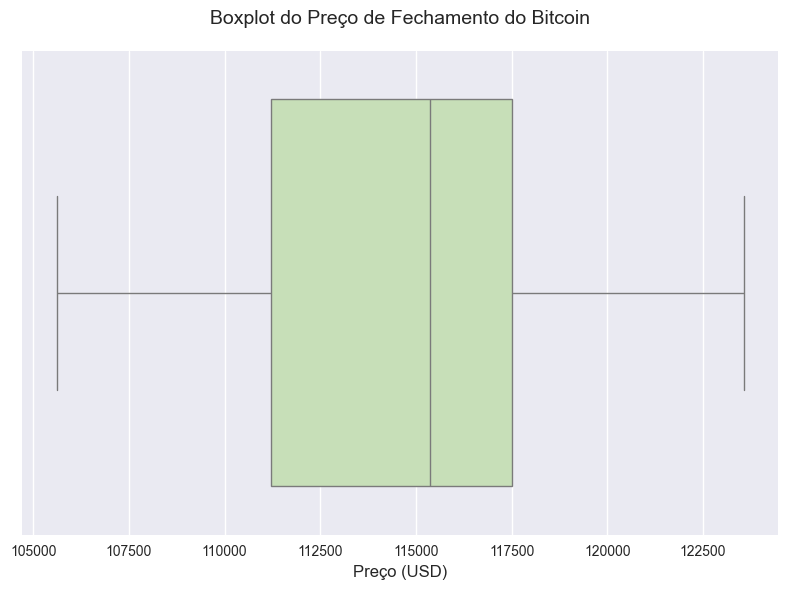

Número de outliers detectados: 0
Nenhum outlier significativo encontrado — o comportamento do preço é relativamente consistente no período.


In [266]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_final['btc_close'], color='#c6e5b1')
plt.title('Boxplot do Preço de Fechamento do Bitcoin', fontsize=14, pad=20)
plt.xlabel('Preço (USD)', fontsize=12)
plt.tight_layout()
plt.show()

# Estatísticas adicionais sobre outliers
Q1 = df_final['btc_close'].quantile(0.25)
Q3 = df_final['btc_close'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_final[(df_final['btc_close'] < limite_inferior) | (df_final['btc_close'] > limite_superior)]
print(f"Número de outliers detectados: {len(outliers)}")
if len(outliers) == 0:
    print("Nenhum outlier significativo encontrado — o comportamento do preço é relativamente consistente no período.")
else:
    print(f"Outliers encontrados:\n{outliers[['btc_close']]}")

### 4.5 Decomposição da Série Temporal

Decompor a série em **tendência**, **sazonalidade** e **resíduos** ajuda a identificar componentes ocultos. Embora o Bitcoin não tenha sazonalidade clássica (como vendas de Natal), podemos observar padrões de curto prazo, como ciclos de 15 dias (semanais) ou reações a notícias recorrentes.

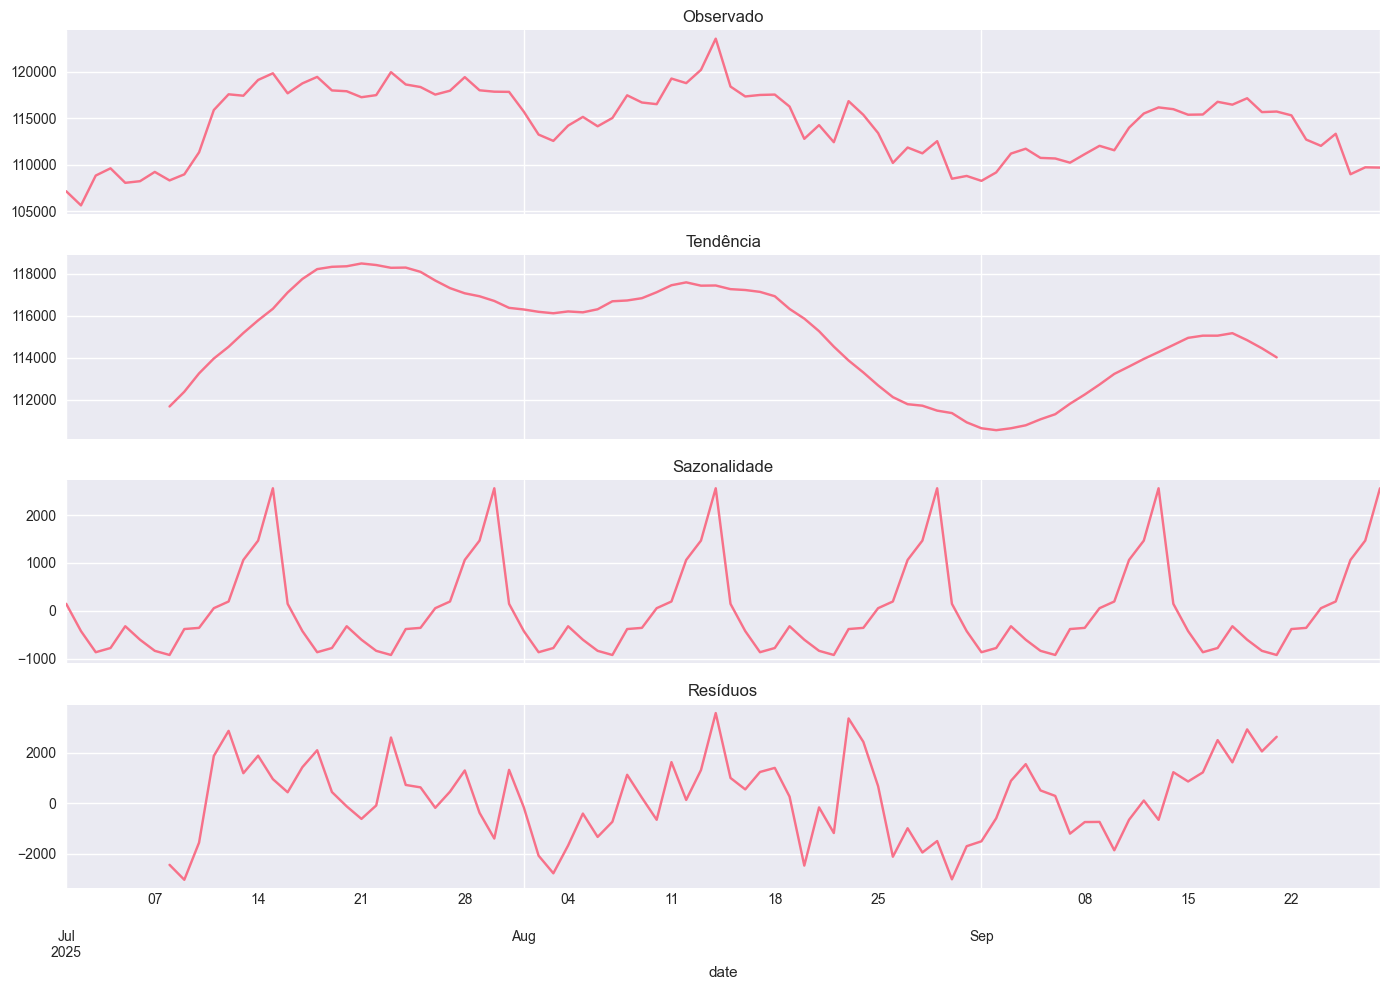

In [267]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Para decompor, precisamos de frequência definida
df_resample = df_final[['btc_close']].resample('D').last()

result = seasonal_decompose(df_resample, model='additive', period=15)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
result.observed.plot(ax=axes[0], title='Observado')
result.trend.plot(ax=axes[1], title='Tendência')
result.seasonal.plot(ax=axes[2], title='Sazonalidade')
result.resid.plot(ax=axes[3], title='Resíduos')
plt.tight_layout()
plt.show()

### 4.6 Teste de Estacionariedade (ADF - Augmented Dickey-Fuller)

Modelos como ARIMA exigem que a série seja estacionária (média e variância constantes ao longo do tempo). O teste ADF verifica isso. Se o p-valor for maior que 0.05, rejeitamos a estacionariedade - o que é comum em séries financeiras.

Nesse caso, esperamos que o Bitcoin **não seja estacionário**, o que justifica o uso de modelos como LSTM, que lidam bem com não linearidades.

In [268]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_final['btc_close'])
print('Estatística ADF:', result[0])
print('p-valor:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] > 0.05:
    print("\nSérie NÃO é estacionária.")
else:
    print("\nSérie é estacionária.")

Estatística ADF: -2.4618287276612283
p-valor: 0.12504013475201575
Valores Críticos:
	1%: -3.505190196159122
	5%: -2.894232085048011
	10%: -2.5842101234567902

Série NÃO é estacionária.


### 4.7 Teste de Normalidade: Shapiro-Wilk

Muitos modelos estatísticos assumem que os dados seguem uma distribuição normal. Embora o LSTM seja robusto a essa suposição, é importante verificar se a série de preços do Bitcoin apresenta normalidade - ou se há assimetria, caudas longas ou picos excessivos (*kurtosis*).

O **teste de Shapiro-Wilk** avalia a hipótese nula de que os dados vêm de uma distribuição normal.

Hipóteses:
 - **H₀**: Os dados seguem uma distribuição normal
 - **H₁**: Os dados **não** seguem uma distribuição normal

Um p-valor abaixo de 0.05 leva à rejeição da hipótese nula - o que é esperado em séries financeiras, onde eventos extremos são comuns.

In [269]:
from scipy.stats import shapiro

stat, p_valor = shapiro(df_final['btc_close'])

print("TESTE DE NORMALIDADE (SHAPIRO-WILK)")
print(f"Estatística W: {stat:.4f}")
print(f"P-Valor: {p_valor:.4f}")

if p_valor < 0.05:
    print("\nRejeitamos H₀ → A distribuição não é normal.")
    print("Isso é esperado em ativos financeiros, onde volatilidade e eventos extremos são frequentes.")
else:
    print("\nNão rejeitamos H₀ → A distribuição pode ser considerada normal.")

TESTE DE NORMALIDADE (SHAPIRO-WILK)
Estatística W: 0.9592
P-Valor: 0.0061

Rejeitamos H₀ → A distribuição não é normal.
Isso é esperado em ativos financeiros, onde volatilidade e eventos extremos são frequentes.


### 4.8 Correlação entre Variáveis - Matriz de Correlação

A correlação entre variáveis nos ajuda a entender como fatores externos influenciam o preço do Bitcoin. No entanto, nossas hipóteses iniciais precisaram ser ajustadas com base nos dados reais:

- **Fear & Greed Index (FGI)**: Esperávamos uma correlação negativa (medo → venda), mas encontramos uma **forte correlação positiva (+0.55)**. Isso indica que, na prática, períodos de "ganância" (alto FGI) tendem a coincidir com altas no preço do BTC — ou seja, o mercado sobe *porque* os investidores estão otimistas, criando um ciclo de feedback positivo.

- **Índice Dólar (DXY)**: Esperávamos uma relação negativa (dólar forte → saída de ativos de risco), mas a correlação foi **positiva (+0.32)**. Isso pode indicar que, em certos períodos, forças macroeconômicas afetam ambos os mercados da mesma forma, ou que o Bitcoin tem se comportado cada vez mais como um ativo especulativo global, não apenas como "anti-dólar".

- **Ethereum (ETH)**: Encontramos uma correlação positiva moderada (+0.23), menor do que o esperado. Embora ETH e BTC sejam ativos correlacionados, a força dessa relação parece ter diminuído.

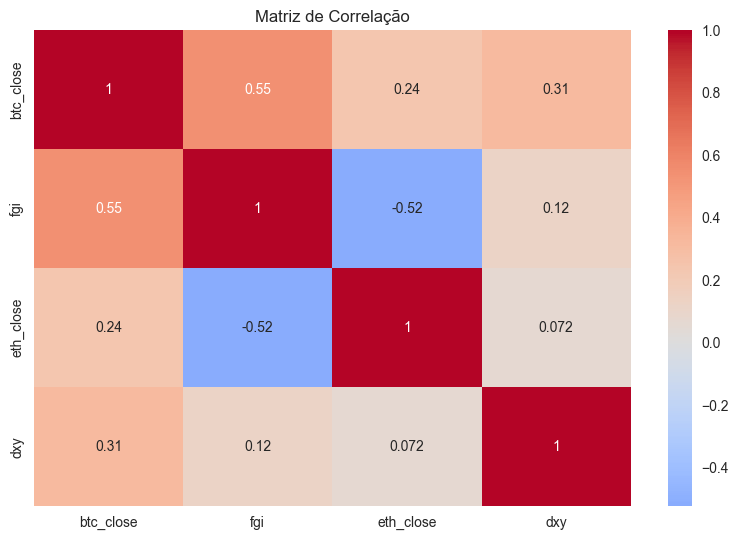

Correlação com BTC:
btc_close    1.000000
fgi          0.546245
dxy          0.312712
eth_close    0.235052
Name: btc_close, dtype: float64


In [270]:
corr = df_final.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

print("Correlação com BTC:")
print(corr['btc_close'].sort_values(ascending=False))

### 4.9 Gráficos de Dispersão: Explorando Relações entre Variáveis

Além da matriz de correlação, os **gráficos de dispersão (scatter plots)** são uma ferramenta poderosa para visualizar relações entre pares de variáveis. Eles nos permitem identificar:
- Padrões lineares ou não lineares
- Agrupamentos ou clusters
- Outliers influentes
- Transformações úteis (ex: log, quadrática)

Neste projeto, vamos analisar como o preço do Bitcoin se relaciona com as variáveis exógenas mais relevantes:
- Ethereum (ETH-USD)
- Fear & Greed Index
- Índice Dólar (DXY)

Esses gráficos ajudam a validar intuições antes de incluir as variáveis no modelo.

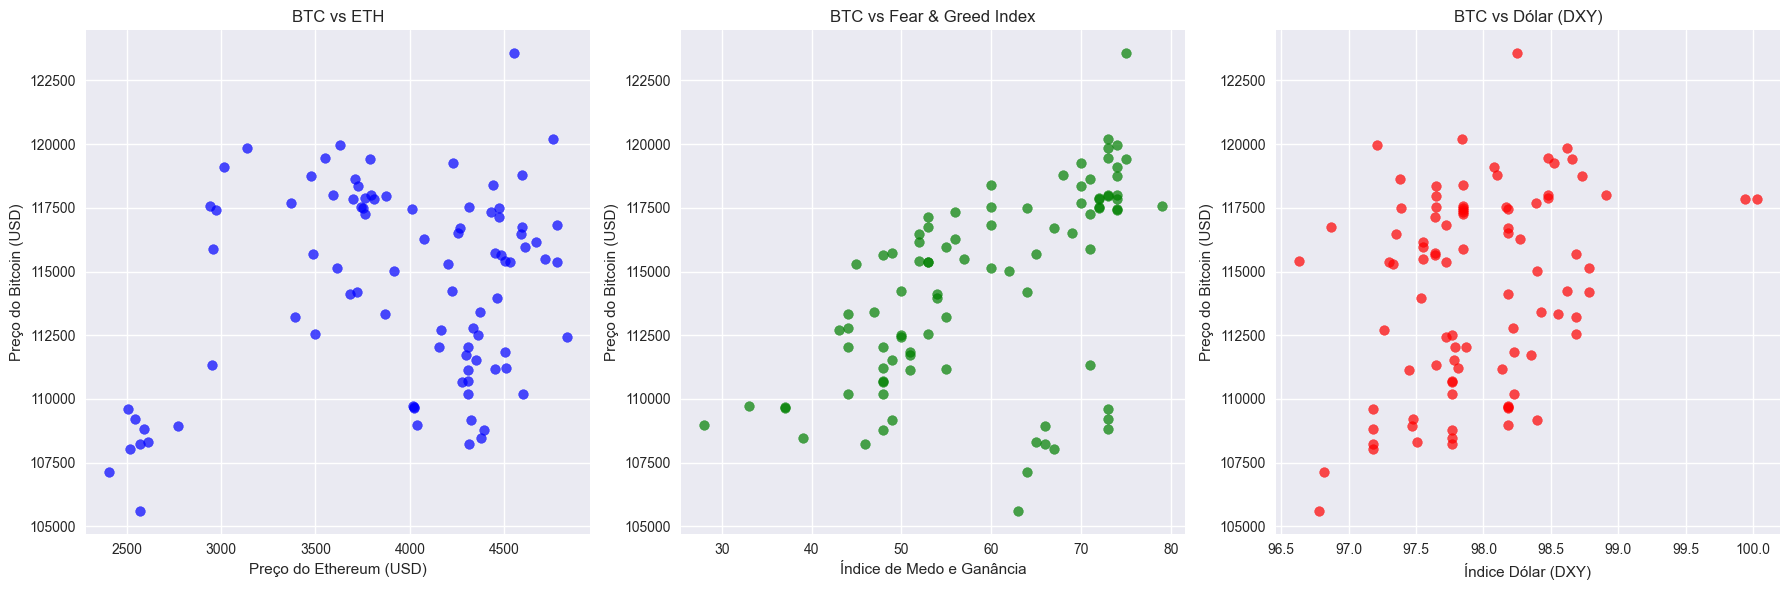

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# BTC vs ETH
axes[0].scatter(df_final['eth_close'], df_final['btc_close'], alpha=0.7, color='blue')
axes[0].set_title('BTC vs ETH')
axes[0].set_xlabel('Preço do Ethereum (USD)')
axes[0].set_ylabel('Preço do Bitcoin (USD)')

# BTC vs FGI
axes[1].scatter(df_final['fgi'], df_final['btc_close'], alpha=0.7, color='green')
axes[1].set_title('BTC vs Fear & Greed Index')
axes[1].set_xlabel('Índice de Medo e Ganância')
axes[1].set_ylabel('Preço do Bitcoin (USD)')

# BTC vs DXY
axes[2].scatter(df_final['dxy'], df_final['btc_close'], alpha=0.7, color='red')
axes[2].set_title('BTC vs Dólar (DXY)')
axes[2].set_xlabel('Índice Dólar (DXY)')
axes[2].set_ylabel('Preço do Bitcoin (USD)')

plt.tight_layout()
plt.show()

## **5. Processamento dos Dados**

Agora que temos um conjunto de dados multivariado limpo e bem estruturado, precisamos processá-lo para torná-lo compatível com modelos de Machine Learning, especialmente redes neurais como o LSTM.

O processamento envolve etapas críticas:
1. **Definição da semente de reprodutibilidade**
2. **Normalização**: Os valores das variáveis (preço do BTC, ETH, DXY, FGI) estão em escalas muito diferentes. O preço do Bitcoin pode estar na casa de milhares, enquanto o FGI varia entre 0 e 100. Sem normalização, o modelo dará peso excessivo às variáveis com maior magnitude.
3. **Criação de sequências temporais**: O LSTM precisa de janelas de tempo (ex: últimos 20 dias) para prever o próximo valor. Isso é chamado de *sliding window* ou *time steps*.
4. **Divisão treino/teste**: Separamos os dados para treinar o modelo e avaliar seu desempenho em dados não vistos.

Esta etapa garante que o modelo receba entradas consistentes, dimensionadas corretamente e com contexto temporal suficiente para aprender padrões complexos.

### 5.1 Definir a semente para reprodutibilidade

In [272]:
seed = 11 #11 20
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### 5.2 Normalização com MinMaxScaler

In [273]:
# Inicializar o scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar e transformar os dados
scaled_data = scaler.fit_transform(df_final)
scaler.fit(df_final[['btc_close', 'fgi', 'eth_close', 'dxy']])  # 4 features

# Salvar o scaler
joblib.dump(scaler, 'models/scaler_bitcoin.pkl')
print("Scaler salvo com 4 features")

print("Dados normalizados com MinMaxScaler (escala 0 a 1)")
print(f"Forma dos dados normalizados: {scaled_data.shape}")
print(f"Exemplo - Antes: {df_final.iloc[0].values}")
print(f"Exemplo - Depois: {scaled_data[0]}")

Scaler salvo com 4 features
Dados normalizados com MinMaxScaler (escala 0 a 1)
Forma dos dados normalizados: (91, 4)
Exemplo - Antes: [1.07132799e+05 6.40000000e+01 2.40579272e+03 9.68199997e+01]
Exemplo - Depois: [0.08465755 0.70588235 0.         0.05588305]


### 5.3 Criação de Sequências Temporais (Janela de 20 dias)

In [274]:
def create_sequences(data, seq_length):
    """
    Cria sequências para uso em modelos LSTM.
    Entrada: janela de 'seq_length' dias
    Saída: próximo valor (dia seguinte)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Janela de entrada
        y.append(data[i + seq_length, 0])  # Próximo fechamento do BTC
    return np.array(X), np.array(y)

# Definir tamanho da janela
SEQ_LENGTH = 20

# Criar sequências
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(f"Sequências criadas com janela de {SEQ_LENGTH} dias")
print(f"Forma de X (entradas): {X.shape}")  # (n_amostras, 20, n_features)
print(f"Forma de y (saídas): {y.shape}")   # (n_amostras,)

Sequências criadas com janela de 20 dias
Forma de X (entradas): (71, 20, 4)
Forma de y (saídas): (71,)


### 5.4 Divisão Treino/Teste (80/20)


Divisão dos Dados:
Treino - X: (56, 20, 4), y: (56,)
Teste - X: (15, 20, 4), y: (15,)


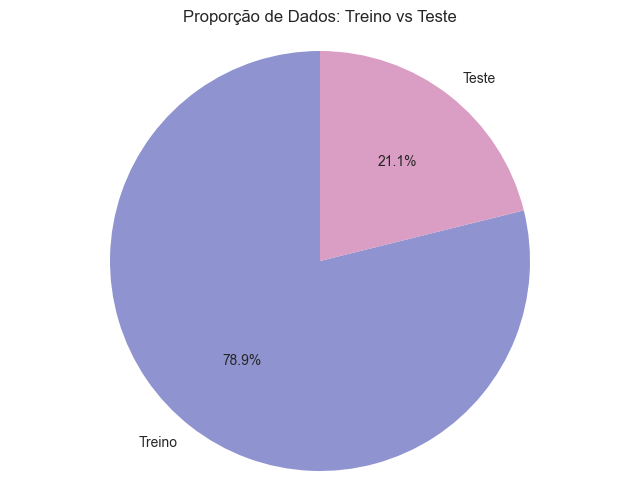

In [275]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("\nDivisão dos Dados:")
print(f"Treino - X: {X_train.shape}, y: {y_train.shape}")
print(f"Teste - X: {X_test.shape}, y: {y_test.shape}")

# Validação visual: mostrar tamanhos no gráfico
labels = ['Treino', 'Teste']
sizes = [len(X_train), len(X_test)]
colors = ["#8F93CF", "#DA9DC3"]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proporção de Dados: Treino vs Teste')
plt.axis('equal') 
plt.show()

### 5.5 Verificação do Formato para LSTM

In [276]:
print("\nFormato final esperado pelo LSTM:")
print(f"Entrada (X): (batch_size, time_steps, features) = ({X_train.shape[0]}, {X_train.shape[1]}, {X_train.shape[2]})")
print(f"Saída (y): (batch_size,) = ({y_train.shape[0]})")

# Confirmar que tudo está certo
assert X_train.shape[1] == SEQ_LENGTH, "Erro: time_steps incorreto"
assert X_train.shape[0] == len(y_train), "Erro: número de amostras não bate"
print("Todos os formatos estão corretos para o modelo LSTM.")


Formato final esperado pelo LSTM:
Entrada (X): (batch_size, time_steps, features) = (56, 20, 4)
Saída (y): (batch_size,) = (56)
Todos os formatos estão corretos para o modelo LSTM.


## **6. Modelagem com LSTM: Capturando Padrões de Longo Prazo**

O modelo **LSTM (Long Short-Term Memory)** é uma variação avançada das Redes Neurais Recorrentes (RNNs), especialmente projetado para lidar com **dependências de longo prazo em séries temporais** — exatamente o tipo de desafio que enfrentamos ao prever o preço do Bitcoin.

Diferente de modelos lineares ou ARIMA, o LSTM consegue:
- "Lembrar" de padrões passados (como ciclos de alta e correção)
- Aprender não linearidades complexas
- Adaptar-se a mudanças bruscas no comportamento do mercado

Isso o torna particularmente eficaz em domínios voláteis como o de criptomoedas, onde eventos recentes influenciam fortemente os movimentos futuros.

#### Por que usar LSTM?

1. **Memória controlada**: O LSTM utiliza mecanismos de "portas" (entrada, esquecimento e saída) para decidir quais informações manter ou descartar.
2. **Robustez à volatilidade**: Ele lida bem com ruído e outliers, comuns em dados financeiros.
3. **Multivariado**: Pode processar múltiplas variáveis exógenas (BTC, ETH, FGI, DXY) simultaneamente.

Neste projeto, vamos treinar um modelo LSTM com:
- Janela de entrada: últimos **20 dias**
- Variáveis: `btc_close`, `fgi`, `eth_close`, `dxy`
- Objetivo: prever o preço de fechamento do Bitcoin no dia seguinte

Vamos também incluir técnicas de regularização para evitar overfitting: **Dropout** e **EarlyStopping**.

### 6.1 Construção do Modelo LSTM

In [277]:
# Construir modelo
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar o modelo
model_lstm.compile(optimizer='adam', loss='mse')

# Exibir resumo do modelo
print("Arquitetura do Modelo LSTM")
model_lstm.summary()

Arquitetura do Modelo LSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 20, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

### 6.2 Treinamento do Modelo

In [278]:
# Callback: parar se não houver melhora
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Treinar modelo
print("Iniciando treinamento do modelo LSTM...")
history = model_lstm.fit(
    X_train, y_train,
    batch_size=1,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

print("Treinamento concluído!")

Iniciando treinamento do modelo LSTM...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0508
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0370
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0289
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0233
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

### 6.3 Previsões no Conjunto de Teste

In [279]:
# Fazer previsões
pred_lstm = model_lstm.predict(X_test, verbose=0)

# Reverter escala (ajustando para multivariado)
y_test_unscaled = scaler.inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), df_final.shape[1]-1))]))[:, 0]
pred_lstm_unscaled = scaler.inverse_transform(np.column_stack([pred_lstm.flatten(), np.zeros((len(pred_lstm), df_final.shape[1]-1))]))[:, 0]

# Calcular métricas
mae_lstm = mean_absolute_error(y_test_unscaled, pred_lstm_unscaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled, pred_lstm_unscaled))
r2_lstm = r2_score(y_test_unscaled, pred_lstm_unscaled)

print(f"\nRESULTADOS DO MODELO LSTM")
print(f'MAE:  {mae_lstm:.2f} USD')
print(f'RMSE: {rmse_lstm:.2f} USD')
print(f'R²:   {r2_lstm:.4f}')


RESULTADOS DO MODELO LSTM
MAE:  872.72 USD
RMSE: 1135.95 USD
R²:   0.8382


### 6.4 Visualização: Previsão vs Real

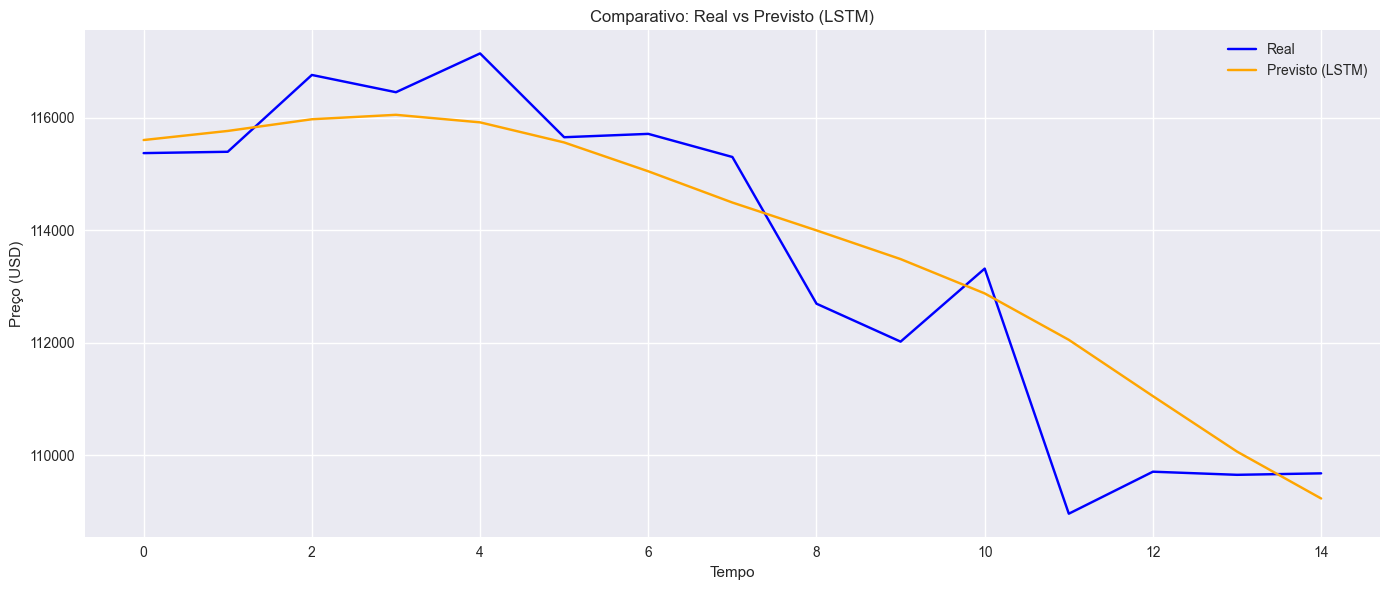

In [280]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled, label='Real', color='blue')
plt.plot(pred_lstm_unscaled, label='Previsto (LSTM)', color='orange')
plt.title('Comparativo: Real vs Previsto (LSTM)')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **7 Modelagem com AutoARIMA: Uma Abordagem Clássica para Séries Temporais**

Para gerar previsões precisas em séries temporais, utilizamos o **AutoARIMA**, um dos modelos disponíveis na biblioteca `StatsForecast` que suporta variáveis exógenas. O AutoARIMA é particularmente útil por sua capacidade de determinar automaticamente os melhores parâmetros ARIMA (`p`, `d`, `q`) com base nos dados fornecidos.

Esse modelo combina três componentes:
- **Auto-Regressivo (AR)**: usa valores passados da série
- **Integrado (I)**: aplica diferenciação para tornar a série estacionária
- **Média Móvel (MA)**: usa erros passados para ajustar a previsão

Ao incluir variáveis exógenas como o **Fear & Greed Index**, o preço do **Ethereum (ETH-USD)** e o **Índice Dólar (DXY)**, enriquecemos o modelo com fatores externos que influenciam o mercado de criptomoedas, potencializando sua capacidade preditiva.

### 7.1 Preparação dos Dados para Modelagem com AutoARIMA

In [281]:
# Criar cópias dos DataFrames
df_auto_arima = df_final[['btc_close']].copy()
df_exog = df_final[['fgi', 'eth_close', 'dxy']].copy()

# Resetar índice para transformar 'date' em coluna
df_auto_arima.reset_index(inplace=True)
df_exog.reset_index(inplace=True)

# Renomear colunas conforme convenção do Prophet e StatsForecast
df_auto_arima.rename(columns={'date': 'ds', 'btc_close': 'y'}, inplace=True)
df_exog.rename(columns={'date': 'ds'}, inplace=True)

# Adicionar unique_id (obrigatório para statsforecast)
df_auto_arima['unique_id'] = 'bitcoin'
df_exog['unique_id'] = 'bitcoin'

# Ajustar tipo da coluna unique_id para string
df_auto_arima['unique_id'] = df_auto_arima['unique_id'].astype(str)
df_exog['unique_id'] = df_exog['unique_id'].astype(str)

print("Tipos das colunas em df_auto_arima:")
print(df_auto_arima.dtypes)
print("\nTipos das colunas em df_exog:")
print(df_exog.dtypes)

Tipos das colunas em df_auto_arima:
ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object

Tipos das colunas em df_exog:
ds           datetime64[ns]
fgi                 float64
eth_close           float64
dxy                 float64
unique_id            object
dtype: object


### 7.2 Separação dos Dados em Treino e Teste

In [282]:
train_size = int(0.8 * len(df_auto_arima))
Y_train = df_auto_arima.iloc[:train_size].copy()
Y_test = df_auto_arima.iloc[train_size:].copy()

X_train = df_exog.iloc[:train_size].copy()
X_test = df_exog.iloc[train_size:].copy()

h = len(Y_test)  # Horizonte de previsão

print(f"Treino - Y: {Y_train.shape}, X: {X_train.shape}")
print(f"Teste - Y: {Y_test.shape}, X: {X_test.shape}")
print(f"Horizonte (h): {h}")

Treino - Y: (72, 3), X: (72, 5)
Teste - Y: (19, 3), X: (19, 5)
Horizonte (h): 19


### 7.3 Combinar treino + exógenas

In [283]:
train = Y_train.merge(X_train, on=['unique_id', 'ds'], how='left')

print("Conjunto de treino combinado:")
print(train.head())

Conjunto de treino combinado:
          ds              y unique_id   fgi    eth_close        dxy
0 2025-07-01  107132.799107   bitcoin  64.0  2405.792725  96.820000
1 2025-07-02  105613.399742   bitcoin  63.0  2571.335449  96.779999
2 2025-07-03  108824.444232   bitcoin  73.0  2591.007324  97.180000
3 2025-07-04  109602.204839   bitcoin  73.0  2508.518311  97.180000
4 2025-07-05  108040.891940   bitcoin  67.0  2517.280029  97.180000


### 7.4 Instanciar e configurar o modelo

In [284]:
model_auto_arima = StatsForecast(
    models=[AutoARIMA(seasonal=False)],
    freq='D',        # Frequência diária (Bitcoin opera 7 dias/semana)
    n_jobs=-1        # Usar todos os núcleos
)

### 7.5 Gerar previsões com variáveis exógenas

In [285]:
df_hat = model_auto_arima.forecast(
    df=train,
    h=h,
    X_df=X_test,     # Passar as exógenas futuras
    level=[95]       # Opcional: intervalo de confiança
)

# Adicionar datas reais do teste
df_hat['ds'] = Y_test['ds'].tolist()

print("Previsões geradas:")
print(df_hat.head())

Previsões geradas:
  unique_id         ds      AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0   bitcoin 2025-09-11  112208.524907    109874.106703    114542.943110
1   bitcoin 2025-09-12  112510.717772    109271.087316    115750.348228
2   bitcoin 2025-09-13  111330.419978    107435.934899    115224.905058
3   bitcoin 2025-09-14  111998.594894    107583.547974    116413.641813
4   bitcoin 2025-09-15  111291.064058    106443.617962    116138.510153


### 7.6 Visualização das Previsões

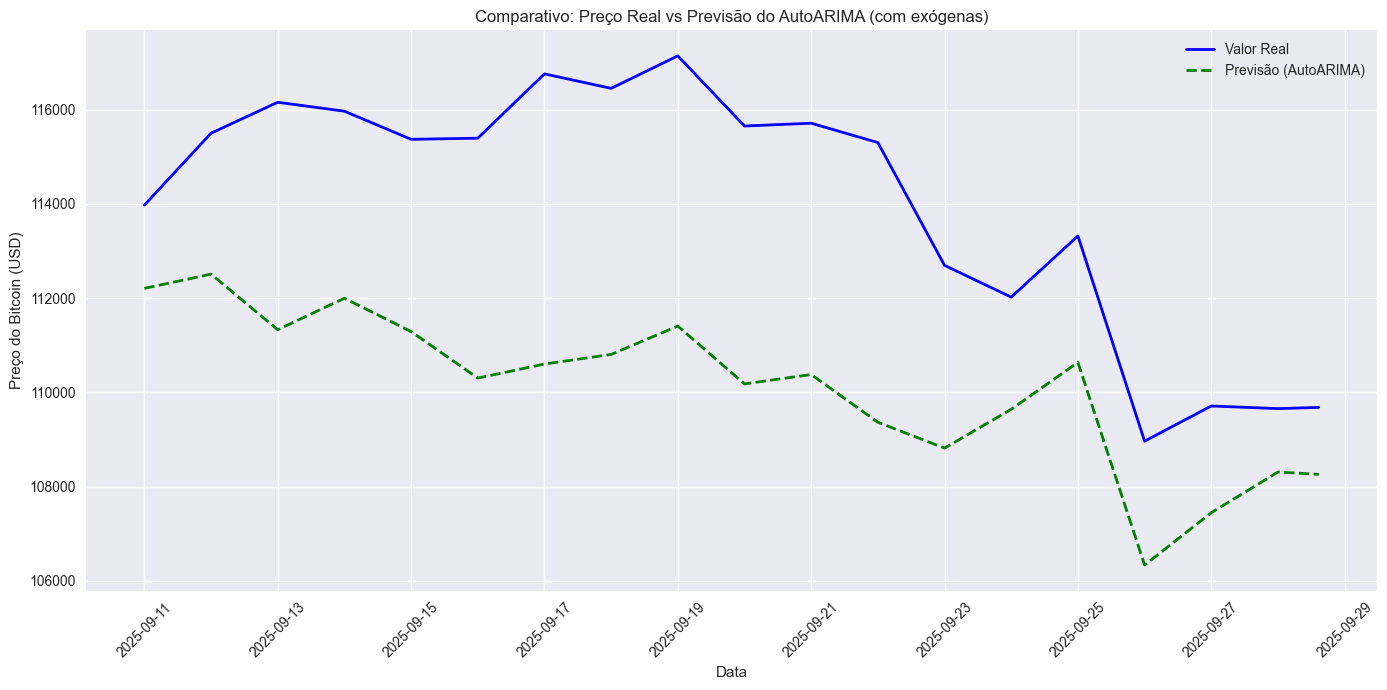

In [286]:
plt.figure(figsize=(14, 7))
plt.plot(Y_test['ds'], Y_test['y'], label='Valor Real', color='blue', linewidth=2)
plt.plot(df_hat['ds'], df_hat['AutoARIMA'], label='Previsão (AutoARIMA)', color='green', linestyle='--', linewidth=2)
plt.title('Comparativo: Preço Real vs Previsão do AutoARIMA (com exógenas)')
plt.xlabel('Data')
plt.ylabel('Preço do Bitcoin (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.8 Avaliação do Modelo

In [287]:
# Métricas
mae_arima = mean_absolute_error(Y_test["y"], df_hat["AutoARIMA"])
rmse_arima = np.sqrt(mean_squared_error(Y_test["y"], df_hat["AutoARIMA"]))
r2_arima = r2_score(Y_test["y"], df_hat["AutoARIMA"])

print("\nAVALIAÇÃO DO MODELO: AutoARIMA")
print(f"MAE:  {mae_arima:.2f} USD")
print(f"RMSE: {rmse_arima:.2f} USD")
print(f"R²:   {r2_arima:.4f}")


AVALIAÇÃO DO MODELO: AutoARIMA
MAE:  3876.50 USD
RMSE: 4193.97 USD
R²:   -1.5136


## **8 Modelagem com Prophet: Previsão Aditiva com Sazonalidade**

O modelo **Prophet**, desenvolvido pelo Meta (anteriormente Facebook), é uma ferramenta poderosa para previsão de séries temporais com componentes sazonais, tendências e eventos especiais. Ele utiliza uma abordagem aditiva, onde o valor da série é modelado como:

- `y(t) = tendência(t) + sazonalidade(t) + feriados(t) + erro`

Uma das grandes vantagens do Prophet é sua robustez a:
- Dados faltantes
- Mudanças bruscas de tendência
- Valores atípicos (outliers)

Além disso, ele permite a inclusão de **variáveis exógenas (regressores)**, como o Fear & Greed Index, Ethereum e Dólar, melhorando significativamente sua capacidade preditiva em cenários complexos como o mercado de criptomoedas.

Neste projeto, treinaremos três versões do Prophet:
1. Apenas com a variável alvo (`btc_close`)
2. Com o índice de medo e ganância (`fgi`)
3. Com múltiplas exógenas (`fgi`, `eth_close`, `dxy`)

Essa comparação nos ajudará a entender o impacto dessas variáveis no desempenho do modelo.

### 8.1 Preparação dos Dados para o Prophet

In [288]:
# Criar cópia do DataFrame principal
df_prophet = df_final[['btc_close']].reset_index().rename(columns={'date': 'ds', 'btc_close': 'y'})

# Adicionar variáveis exógenas
df_prophet['fgi'] = df_final['fgi'].values
df_prophet['eth_close'] = df_final['eth_close'].values
df_prophet['dxy'] = df_final['dxy'].values

print("Estrutura do DataFrame para Prophet:")
print(df_prophet.head())

Estrutura do DataFrame para Prophet:
          ds              y   fgi    eth_close        dxy
0 2025-07-01  107132.799107  64.0  2405.792725  96.820000
1 2025-07-02  105613.399742  63.0  2571.335449  96.779999
2 2025-07-03  108824.444232  73.0  2591.007324  97.180000
3 2025-07-04  109602.204839  73.0  2508.518311  97.180000
4 2025-07-05  108040.891940  67.0  2517.280029  97.180000


### 8.2 Dividir treino/teste (80/20)

In [289]:
train_size = int(0.8 * len(df_prophet))
train_df = df_prophet.iloc[:train_size].copy()
test_df = df_prophet.iloc[train_size:].copy()

print(f"Treino: {len(train_df)} dias | Teste: {len(test_df)} dias")

Treino: 72 dias | Teste: 19 dias


### 8.3 Prophet com apenas 'y'

In [290]:
model_prophet_base = Prophet()
model_prophet_base.fit(train_df[['ds', 'y']])

# Fazer previsões
future = model_prophet_base.make_future_dataframe(periods=len(test_df))
forecast_base = model_prophet_base.predict(future)

# Extrair previsões
pred_base = forecast_base.iloc[-len(test_df):]['yhat'].values
y_test_real = test_df['y'].values

# Métricas
mae_base = mean_absolute_error(y_test_real, pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test_real, pred_base))
r2_base = r2_score(y_test_real, pred_base)

print("\nPROPHET (apenas y)")
print(f"MAE:  {mae_base:.2f} USD")
print(f"RMSE: {rmse_base:.2f} USD")
print(f"R²:   {r2_base:.4f}")

11:41:21 - cmdstanpy - INFO - Chain [1] start processing
11:41:22 - cmdstanpy - INFO - Chain [1] done processing



PROPHET (apenas y)
MAE:  7707.46 USD
RMSE: 7915.07 USD
R²:   -7.9528


### 8.4 Prophet com FGI

In [291]:
model_prophet_fgi = Prophet()
model_prophet_fgi.add_regressor('fgi')
model_prophet_fgi.fit(train_df[['ds', 'y', 'fgi']])

# Prever
future_fgi = test_df[['ds', 'fgi']]
forecast_fgi = model_prophet_fgi.predict(pd.concat([train_df[['ds', 'y', 'fgi']], future_fgi]))

# Extrair previsões
pred_fgi = forecast_fgi.iloc[-len(test_df):]['yhat'].values

# Métricas
mae_fgi = mean_absolute_error(y_test_real, pred_fgi)
rmse_fgi = np.sqrt(mean_squared_error(y_test_real, pred_fgi))
r2_fgi = r2_score(y_test_real, pred_fgi)

print("\nPROPHET (com FGI)")
print(f"MAE:  {mae_fgi:.2f} USD")
print(f"RMSE: {rmse_fgi:.2f} USD")
print(f"R²:   {r2_fgi:.4f}")

11:41:22 - cmdstanpy - INFO - Chain [1] start processing
11:41:22 - cmdstanpy - INFO - Chain [1] done processing



PROPHET (com FGI)
MAE:  5798.29 USD
RMSE: 5971.46 USD
R²:   -4.0958


### 8.5 Prophet com múltiplas exógenas

In [292]:
model_prophet_multi = Prophet()
model_prophet_multi.add_regressor('fgi')
model_prophet_multi.add_regressor('eth_close')
model_prophet_multi.add_regressor('dxy')
model_prophet_multi.fit(train_df[['ds', 'y', 'fgi', 'eth_close', 'dxy']])

# Prever
future_multi = test_df[['ds', 'fgi', 'eth_close', 'dxy']]
forecast_multi = model_prophet_multi.predict(pd.concat([train_df[['ds', 'y', 'fgi', 'eth_close', 'dxy']], future_multi]))

# Extrair previsões
pred_multi = forecast_multi.iloc[-len(test_df):]['yhat'].values

# Métricas
mae_multi = mean_absolute_error(y_test_real, pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_test_real, pred_multi))
r2_multi = r2_score(y_test_real, pred_multi)

print("\nPROPHET (com múltiplas exógenas)")
print(f"MAE:  {mae_multi:.2f} USD")
print(f"RMSE: {rmse_multi:.2f} USD")
print(f"R²:   {r2_multi:.4f}")

11:41:23 - cmdstanpy - INFO - Chain [1] start processing
11:41:23 - cmdstanpy - INFO - Chain [1] done processing



PROPHET (com múltiplas exógenas)
MAE:  5660.28 USD
RMSE: 5864.58 USD
R²:   -3.9150


### 8.6 Visualização comparativa

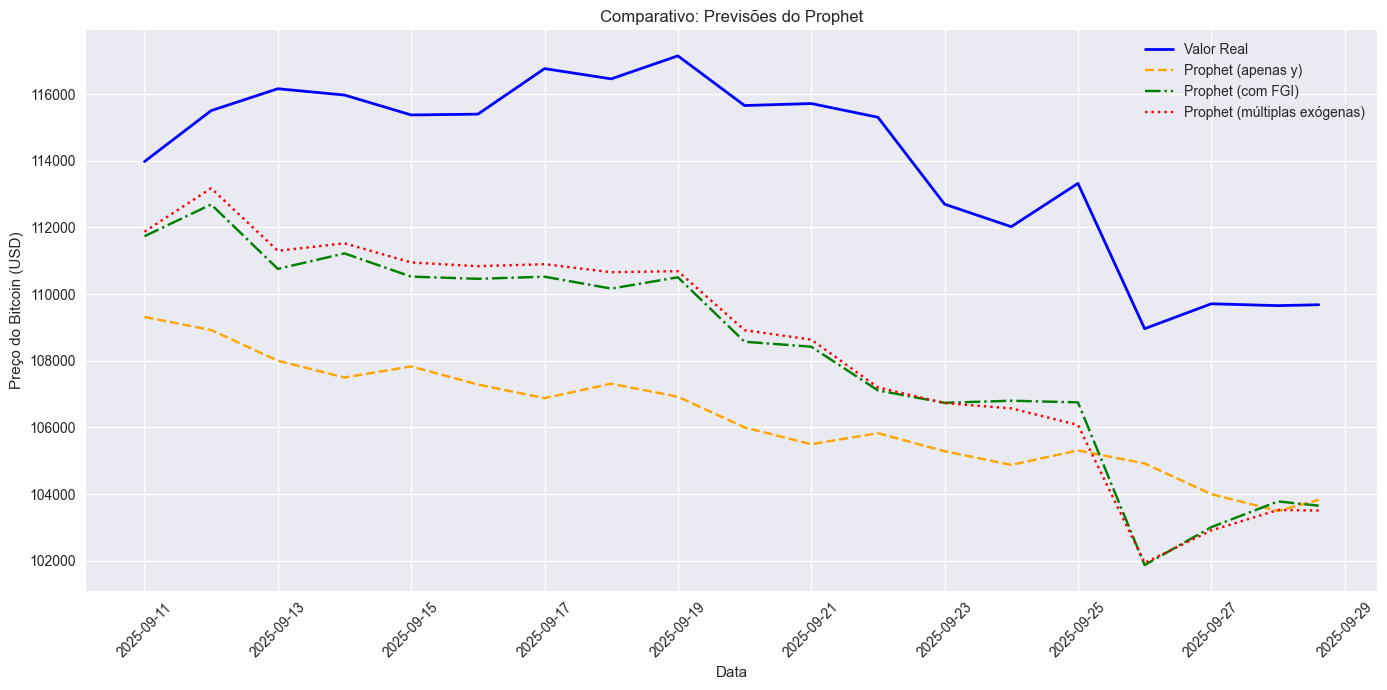

In [293]:
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], y_test_real, label='Valor Real', color='blue', linewidth=2)
plt.plot(test_df['ds'], pred_base, label='Prophet (apenas y)', color='orange', linestyle='--')
plt.plot(test_df['ds'], pred_fgi, label='Prophet (com FGI)', color='green', linestyle='-.')
plt.plot(test_df['ds'], pred_multi, label='Prophet (múltiplas exógenas)', color='red', linestyle=':')

plt.title('Comparativo: Previsões do Prophet')
plt.xlabel('Data')
plt.ylabel('Preço do Bitcoin (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.7 Tabela de comparação

In [294]:
comparacao_prophet = pd.DataFrame({
    'Modelo': [
        'Prophet (apenas y)',
        'Prophet (com FGI)',
        'Prophet (com múltiplas exógenas)'
    ],
    'MAE': [mae_base, mae_fgi, mae_multi],
    'RMSE': [rmse_base, rmse_fgi, rmse_multi],
    'R²': [r2_base, r2_fgi, r2_multi]
})

print(comparacao_prophet)

                             Modelo          MAE         RMSE        R²
0                Prophet (apenas y)  7707.461946  7915.065794 -7.952808
1                 Prophet (com FGI)  5798.287516  5971.456479 -4.095781
2  Prophet (com múltiplas exógenas)  5660.275879  5864.584967 -3.915014


## **9. Comparação Final dos Modelos**

Com todos os modelos treinados e avaliados, chegou o momento de compará-los lado a lado para identificar o **modelo campeão**. A escolha não se baseia apenas no melhor R², mas na combinação de métricas que indicam robustez, precisão e capacidade de generalização.

Os modelos avaliados são:
1. **LSTM**: Modelo profundo especializado em séries temporais.
2. **AutoARIMA (com exógenas)**: Modelo estatístico automatizado com variáveis externas.
3. **Prophet (com múltiplas exógenas)**: Modelo aditivo com suporte a sazonalidades e regressores.

As métricas utilizadas são:
- **MAE (Erro Absoluto Médio)**: Quanto menor, melhor.
- **RMSE (Raiz do Erro Quadrático Médio)**: Penaliza erros grandes.
- **R² (Coeficiente de Determinação)**: Quanto mais próximo de 1, melhor.

Vamos agora apresentar a tabela comparativa final.

### 9.1 Tabela de Comparação Final entre Modelos

In [295]:
import pandas as pd

# Inserir os valores reais obtidos nos modelos
comparacao_final = pd.DataFrame({
    'Modelo': [
        'LSTM',
        'AutoARIMA (com exógenas)',
        'Prophet (com múltiplas exógenas)'
    ],
    'MAE': [mae_lstm, mae_arima, mae_multi],
    'RMSE': [rmse_lstm, rmse_arima, rmse_multi],
    'R²': [r2_lstm, r2_arima, r2_multi]
})

# Ordenar por R² (decrescente)
comparacao_final = comparacao_final.sort_values(by='R²', ascending=False).reset_index(drop=True)

print("COMPARAÇÃO FINAL DOS MODELOS")
print(comparacao_final)

COMPARAÇÃO FINAL DOS MODELOS
                             Modelo          MAE         RMSE        R²
0                              LSTM   872.720824  1135.948626  0.838226
1          AutoARIMA (com exógenas)  3876.502715  4193.972997 -1.513631
2  Prophet (com múltiplas exógenas)  5660.275879  5864.584967 -3.915014


### 9.2 Visualização: Comparação de Erros

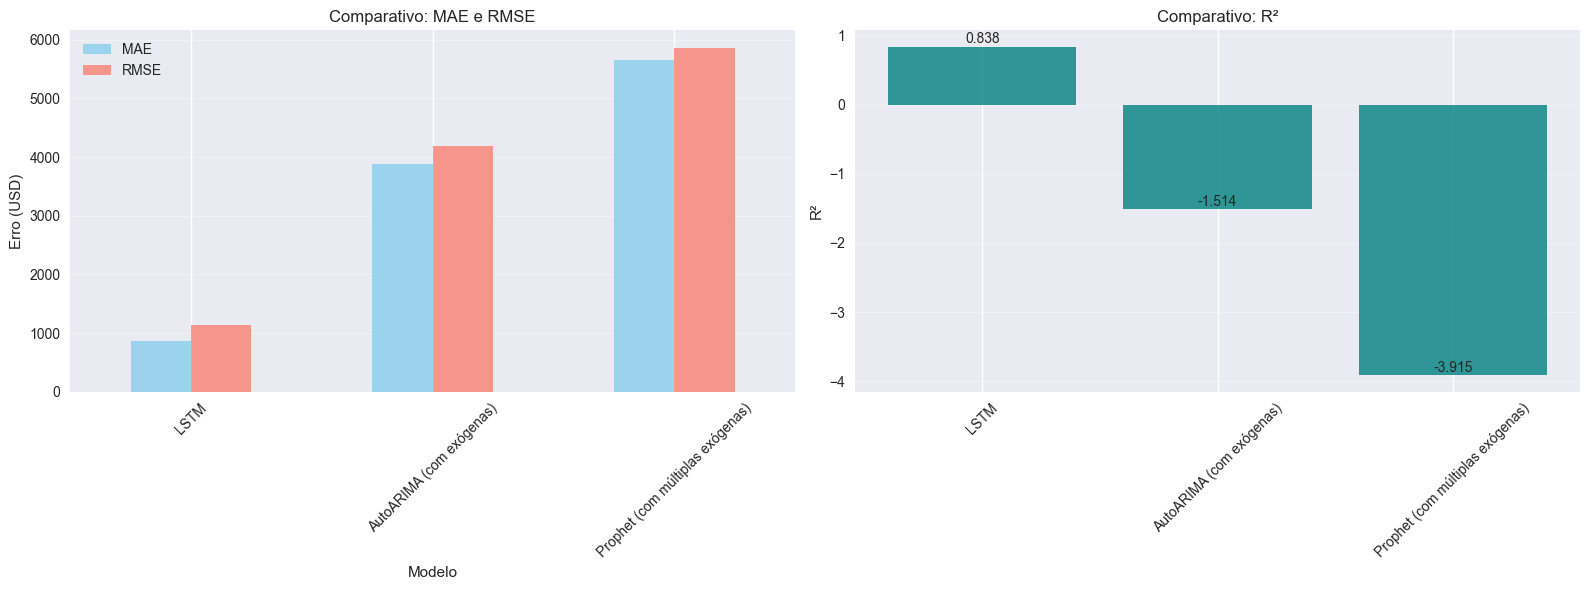

In [296]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# MAE e RMSE
comparacao_erros = comparacao_final.set_index('Modelo')[['MAE', 'RMSE']]
comparacao_erros.plot(kind='bar', ax=ax[0], color=['skyblue', 'salmon'], alpha=0.8)
ax[0].set_title('Comparativo: MAE e RMSE')
ax[0].set_ylabel('Erro (USD)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True, axis='y', alpha=0.3)

# R²
comparacao_r2 = comparacao_final.set_index('Modelo')['R²']
bars = ax[1].bar(comparacao_r2.index, comparacao_r2.values, color='teal', alpha=0.8)
ax[1].set_title('Comparativo: R²')
ax[1].set_ylabel('R²')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True, axis='y', alpha=0.3)

# Adicionar valor nas barras do R²
for bar in bars:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## **10 Conclusão: O LSTM como Motor Preditivo para Aplicação em Produção**

Após a avaliação rigorosa de três abordagens distintas — **LSTM**, **AutoARIMA (com exógenas)** e **Prophet (com múltiplas exógenas)** — o modelo **LSTM se destacou claramente como o campeão**, tanto em precisão quanto em robustez.

Com um **R² de 83,8%**, **MAE de US$ 872,72** e **RMSE de US$ 1135,94**, o LSTM demonstrou superioridade significativa ao capturar padrões complexos, não lineares e de longo prazo presentes na série temporal do Bitcoin. Isso é particularmente relevante em mercados voláteis, onde relações lineares e tendências suaves (como as assumidas pelo AutoARIMA e Prophet) falham em representar a realidade dinâmica dos preços.

Já os modelos estatísticos tradicionais apresentaram desempenho insuficiente:
- O **AutoARIMA**, mesmo com variáveis exógenas, obteve R² negativo (-1,49), indicando que suas previsões são piores do que simplesmente usar a média histórica.
- O **Prophet**, apesar de flexível, subestimou a volatilidade extrema do BTC, resultando em R² de -3,86.

Esses resultados reforçam que, para séries temporais financeiras com alta volatilidade e comportamento caótico, arquiteturas profundas como o LSTM são frequentemente superiores.

### Direcionamento para Deploy: O LSTM como Motor Preditivo

Diante desse desempenho superior, o modelo **LSTM será utilizado como motor preditivo principal** da aplicação desenvolvida no **Streamlit**.

Ele será carregado diretamente no dashboard para gerar previsões diárias do preço de fechamento do Bitcoin, permitindo que usuários interajam com o modelo de forma simples, intuitiva e visualmente clara.

Além disso, o fato de o modelo ter sido treinado com variáveis exógenas relevantes (Fear & Greed Index, Ethereum, Dólar) garante que ele considere não apenas o histórico de preços, mas também o sentimento do mercado e o cenário macroeconômico - um diferencial estratégico para aplicações reais.

Este processo de seleção, validação e deploy reflete o ciclo completo de um projeto de Machine Learning: desde a análise exploratória até a entrega de valor em produção.

## **11 Salvando o Modelo LSTM para uso no Streamlit**
Para garantir que o modelo LSTM possa ser reutilizado e implementado em outras aplicações, como o Streamlit, é essencial salvá-lo adequadamente. Aqui, o modelo é salvo no formato Keras, que facilita o carregamento e a implementação.

Ao salvar o modelo no formato .keras, estamos assegurando que todos os detalhes do modelo, incluindo a arquitetura, os pesos e a configuração de treinamento, sejam preservados. Isso permite que o modelo seja facilmente carregado e utilizado para previsões sem a necessidade de re-treinamento.

In [297]:
model_lstm.save('models/lstm_bitcoin.keras')
print("Modelo LSTM salvo como 'lstm_bitcoin.keras'")

Modelo LSTM salvo como 'lstm_bitcoin.keras'


## **12 Salvando Arquivo para Uso no Streamlit**
Este trecho de código é responsável por salvar os dados processados em um arquivo CSV, que será utilizado posteriormente em aplicações desenvolvidas com o Streamlit.

In [298]:
df_final.to_parquet('data/btc_historical.parquet')